In [1]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.special import stirling2
import math
from copy import copy
import scipy
import tqdm
import pandas as pd

In [2]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

In [3]:
rng = np.random.default_rng(643)

# SDP Minimal Working Example

# Multivariate utils

In [4]:
def compute_order(alpha):
    '''Sum of elements of a power.'''
    order = 0
    for alpha_i in alpha:
        order += alpha_i
    return order

def compute_Nd(S, d):
    '''Number of moments of order <= d (S species)'''
    Nd = math.factorial(S + d) // (math.factorial(d) * math.factorial(S))
    return Nd

def compute_powers(S, d):
    '''Compute the Nd powers of order <= d (S species)'''

    # all powers
    powers = [[0 for s in range(S)]]

    # powers of order d = 0
    powers_prev = [[0 for s in range(S)]]

    # for order d = 1, ..., d
    for order in range(1, d + 1):

        # store powers of order d
        powers_current = []

        # for each power of order d - 1
        for alpha in powers_prev:

            # for each index
            for i in range(S):

                # add 1 to power at index
                alpha_new = copy(alpha)
                alpha_new[i] += 1

                # store (avoid repeats)
                if alpha_new not in powers_current:
                    powers_current.append(alpha_new)

        # update d - 1 powers
        powers += powers_current

        # update overall powers
        powers_prev = powers_current

    return powers

def add_powers(*powers, S):
    '''Add powers (lists) of size S.'''
    plus = [0 for i in range(S)]
    for i in range(S):
        for power in powers:
            plus[i] += power[i]
    return plus

def falling_factorial(n, k):
    '''FF(n,k) = n(n-1) ... (n - k + 1).'''
    val = 1
    for i in range(k):
        val *= (n - i)
    return val

def binomial_moment(n, p, l):
    '''For X ~ Bin(n, p) compute E[X^l].'''
    val = 0
    for k in range(l + 1):
        val += falling_factorial(n, k) * stirling2(l, k) * p**k
    return val

# Bootstrap

In [5]:
def bootstrap(sample, d, resamples=None, confidence=0.95):
    '''
    Compute confidence intervals on the moments of a sample of count pairs, use
    resamples number of bootstrap resamples (default to sample size) and estimate
    moments up to order d.

    Args:
        sample: list of tuples (x1, x2) of integer counts per cell
        d: maximum moment order to estimate
        resamples: integer number of bootstrap resamples to use

    Returns:
        (2 x Nd) numpy array of CI bounds on each Nd moment of order <= d
    '''

    # get sample size
    n = len(sample)

    # get bootstrap size: default to sample size
    if resamples is None:
        resamples = n

    # helpful values
    powers = compute_powers(S=2, d=d)
    Nd = compute_Nd(S=2, d=d)

    # initialize random generator
    rng = np.random.default_rng()

    # convert string to tuple if neccessary (pandas reading csv to string)
    #if type(sample[0]) == str:
    #    sample = [literal_eval(count_pair) for count_pair in sample]

    # separate sample pairs
    x1_sample = [x[0] for x in sample]
    x2_sample = [x[1] for x in sample]

    # convert sample to n x 2 array
    sample = np.array([x1_sample, x2_sample]).T

    # bootstrap to N x n x 2 array
    boot = rng.choice(sample, size=(resamples, n))

    # split into 2 N x n arrays
    x1_boot = boot[:, :, 0]
    x2_boot = boot[:, :, 1]

    # estimate
    moment_bounds = np.zeros((2, Nd))
    for i, alpha in enumerate(powers):

        # raise boot to powers
        x1_boot_alpha = x1_boot**alpha[0]
        x2_boot_alpha = x2_boot**alpha[1]

        # multiply (N x n)
        boot_alpha = x1_boot_alpha * x2_boot_alpha

        # mean over sample axis (N x 1)
        moment_estimates = np.mean(boot_alpha, axis=1)

        # quantile over boot axis (2 x 1)
        alpha = 1 - confidence
        moment_interval = np.quantile(moment_estimates, [(alpha / 2), 1 - (alpha / 2)])

        # store
        moment_bounds[:, i] = moment_interval

    return moment_bounds

# Downsampling

In [6]:
def downsample_data(sample, mean_capture):

    n = len(sample)

    b = (1 / mean_capture) - 1

    # capture efficiency
    if b == 0:
        beta = np.ones(n)
    else:
        beta = rng.beta(1, b, size=1000)

    # split
    x1_sample = [x[0] for x in sample]
    x2_sample = [x[1] for x in sample]

    # downsample
    x1_downsample = rng.binomial(x1_sample, beta).tolist()
    x2_downsample = rng.binomial(x2_sample, beta).tolist()

    # combine
    downsample = list(zip(x1_downsample, x2_downsample))

    return downsample, beta

# Moment equations

In [7]:
def compute_A(alpha, reactions, vrs, db, R, S, d):
    '''
    Moment equation coefficient matrix
    NOTE: must have order of alpha <= d

    Args:
        alpha: moment order for equation (d/dt mu^alpha = 0)
        reactions: list of strings detailing a_r(x) for each reaction r
        vrs: list of lists detailing v_r for each reaction r
        db: largest order a_r(x)
        R: number of reactions
        S: number of species
        d: maximum moment order used (must be >= order(alpha) + db - 1)

    Returns:
        A: (R, Nd) matrix of coefficients
    '''

    if compute_order(alpha) > d - db + 1:
        raise NotImplementedError(f"Maximum moment order {d} too small for moment equation of alpha = {alpha}: involves moments of higher order.")

    xs = sp.symbols([f'x{i}' for i in range(S)])

    # reaction propensity polynomials
    # props = [eval(str_ar) for str_ar in reactions]
    props = [sp.parse_expr(str_ar, {'xs': xs}) for str_ar in reactions]

    # number of moments of order <= d
    Nd = compute_Nd(S, d)

    # get powers of order <= d
    powers = compute_powers(S, d)

    # setup matrix
    A = np.zeros((R, Nd))

    for r, prop in enumerate(props):

        # expand b(x) * ((x + v_r)**alpha - x**alpha)
        term_1 = 1
        term_2 = 1
        for i in range(S):
            term_1 = term_1 * (xs[i] + vrs[r][i])**alpha[i]
            term_2 = term_2 * xs[i]**alpha[i]
        poly = sp.Poly(prop * (term_1 - term_2), xs)

        # loop over terms
        for xs_power, coeff in zip(poly.monoms(), poly.coeffs()):

            # get matrix index
            col = powers.index(list(xs_power))

            # store
            A[r, col] = coeff

    return A

# B Capture matrix

In [8]:
def compute_B(beta, S, U, d):
    '''
    Capture efficiency moment scaling matrix

    Args:
        beta: per cell capture efficiency sample
        S: number of species
        U: unobserved species indices
        d: maximum moment order used

    Returns:
        B: (Nd, Nd) matrix of coefficients
    '''

    # number of moments of order <= d
    Nd = compute_Nd(S, d)

    # compute powers of order <= d
    powers = compute_powers(S, d)

    # compute beta moments of order <= d
    y_beta = np.zeros(d + 1)
    for l in range(d + 1):
        y_beta[l] = np.mean(beta**l)

    # setup matrix
    B = np.zeros((Nd, Nd))

    p = sp.Symbol('p')
    xs = sp.symbols([f'x{i}' for i in range(S)])

    # for each moment power
    for row, alpha in enumerate(powers):

        # setup polynomail
        poly_alpha = 1

        # for each species
        for i in range(S):

            # unobserved: no capture efficiency
            if i in U:
                moment = xs[i]**alpha[i]

            # observed: compute moment expression for E[Xi^alphai] in xi
            else:
                moment = binomial_moment(xs[i], p, alpha[i])
            
            poly = sp.Poly(moment, p, xs[i])

            # multiply
            poly_alpha = poly_alpha * poly

        # loop over terms
        for (beta_power, *xs_power), coeff in zip(poly_alpha.monoms(), poly_alpha.coeffs()):

            # get matrix index
            col = powers.index(xs_power)

            B[row, col] += coeff * y_beta[beta_power]

    return B

# Moment matrices

In [9]:
def construct_M_s(y, s, S, d):
    '''Moment matrix variable constructor (s).'''
    if s == 0:
        D = math.floor(d / 2)
    else:
        D = math.floor((d - 1) / 2)
    powers_D = compute_powers(S, D)
    powers_d = compute_powers(S, d)
    ND = compute_Nd(S, D)
    M_s = [[0 for j in range(ND)] for i in range(ND)]
    e_s = [1 if i == (s - 1) else 0 for i in range(S)]
    for alpha_index, alpha in enumerate(powers_D):
        for beta_index, beta in enumerate(powers_D):
            plus = add_powers(alpha, beta, e_s, S=S)
            plus_index = powers_d.index(plus)
            M_s[alpha_index][beta_index] = y[plus_index].item()
    M_s = gp.MVar.fromlist(M_s)
    return M_s

# NLP base model

In [ ]:
def base_model(model, OB_bounds, beta, reactions, vrs, db, R, S, U, d_bd, b_me, d_sd, constraints, fixed=[], time_limit=300, K=100):
    '''
    Construct 'base model' with semidefinite constraints removed to give NLP

    Args:
        opt: Optimization class (or subclass), see relevant attributes
        model: empty gurobi model object
        OB_bounds: confidence intervals on observed moments up to order d (at least)

        Relevant class attributes

        beta: capture efficiency vector
        reactions: list of strings detailing a_r(x) for each reaction r
        vrs: list of lists detailing v_r for each reaction r
        db: largest order a_r(x)
        R: number of reactions
        S: number of species
        U: indices of unobserved species
        d: maximum moment order used
            d_bd: _ for moment bounds
            d_me: _ for moment equations
            d_sd: _ for semidefinite constraints
        fixed: list of pairs of (reaction index r, value to fix k_r to)
        time_limit: optimization time limit

        constraint options

        moment_bounds: CI bounds on moments
        moment_matrices: 
        moment_equations
        factorization
        factorization_telegraph
        telegraph_moments

    Returns:
        model: gurobi model object with NLP constraints (all but semidefinite)
        variables: dict for model variable reference
    '''

    # compute the highest order moment required
    d = max(d_bd, d_me, d_sd)

    # model settings
    model.Params.TimeLimit = time_limit

    # helpful values
    Nd = compute_Nd(S, d)

    # variables
    y = model.addMVar(shape=Nd, vtype=GRB.CONTINUOUS, name="y", lb=0)
    k = model.addMVar(shape=R, vtype=GRB.CONTINUOUS, name="k", lb=0, ub=K)

    # variable dict
    variables = {
        'y': y,
        'k': k
    }

    if constraints['moment_matrices']:

        # moment matrices
        for s in range(S + 1):
            # restrict to d_sd
            M_s = construct_M_s(y, s, S, d_sd)
            variables[f'M_{s}'] = M_s
    
    # constraints

    if constraints['moment_bounds']:

        '''
        # get CI bounds on OB moments (up to order d)
        y_lb = OB_bounds[0, :]
        y_ub = OB_bounds[1, :]

        # B scaling matrix
        B = compute_B(opt.dataset.beta, opt.S, opt.U, opt.d)

        # moment bounds
        model.addConstr(B @ y <= y_ub, name="y_UB")
        model.addConstr(B @ y >= y_lb, name="y_LB")
        '''

        # Alternate method:
        # do not adjust bounds (in optimization.py)
        # define downsampled moments y_d = B @ y
        # only explicitly bound observed, leave unobserved unbounded
        # avoids issues with e+100 upper bounds on unobserved moments
        # ------------------------------------------------------------

        # B scaling matrix
        B = compute_B(beta, S, U, d)

        # downsampled moments
        y_D = B @ y

        # default >= 0
        model.addConstr(y_D >= 0, name=f"y_LB")

        # bound
        O = [i for i in range(S) if i not in U]
        # only bound up to order d_bd
        powers_S = compute_powers(S, d_bd)
        powers_2 = compute_powers(2, d_bd)
        for i, alpha_S in enumerate(powers_S):
            # check if unobserved moment (non-zero power of unobserved species)
            observed = True
            for j, alpha_j in enumerate(alpha_S):
                if (j in U) and (alpha_j > 0):
                    observed = False
            # observed: bound
            if observed:
                alpha_2 = [alpha_S[i] for i in O]
                j = powers_2.index(alpha_2)
                model.addConstr(y_D[i] <= OB_bounds[1, j], name=f"y_{i}_UB")
                model.addConstr(y_D[i] >= OB_bounds[0, j], name=f"y_{i}_LB")

        # -------------------------------------------------------------

    if constraints['moment_equations']:
                   
        # moment equations (order(alpha) <= d_me - db + 1)
        # d_me = highest order moment present in equations
        # i.e. moment equation of order(alpha) = d_me - db + 1 will use moment of order d_me (as highest)
        moment_powers = compute_powers(S, d_me - db + 1)
        for alpha in moment_powers:
            # compute A as R x N_d, so no need to subset to d_me
            A_alpha_d = compute_A(alpha, reactions, vrs, db, R, S, d)
            model.addConstr(k.T @ A_alpha_d @ y == 0, name=f"ME_{alpha}_{d}")

    if constraints['factorization']:

        # factorization bounds
        powers = compute_powers(S, d)
        for i, alpha in enumerate(powers):

            # E[X1^a1 X2^a2] = E[X1^a1] E[X2^a2]
            if (alpha[0] > 0) and (alpha[1] > 0):
                j = powers.index([alpha[0], 0])
                l = powers.index([0, alpha[1]])
                model.addConstr(y[i] == y[j] * y[l], name=f"Moment_factorization_{alpha[0]}_({alpha[1]})")

    if constraints['telegraph_factorization']:

        # factorization bounds
        powers = compute_powers(S, d)
        for i, alpha in enumerate(powers):

            # E[X1^a1 X2^a2 G1^a3 G2^a4] = E[X1^a1 G1^a3] E[X2^a2 G2^a4]
            if (alpha[0] > 0) and (alpha[1] > 0):
                j = powers.index([alpha[0], 0, alpha[2], 0])
                l = powers.index([0, alpha[1], 0, alpha[3]])
                model.addConstr(y[i] == y[j] * y[l], name=f"Moment_factorization_{alpha[0], alpha[2]}_({alpha[1], alpha[3]})")

    if constraints['telegraph_moments']:

        # telegraph moment equality (as Gi in {0, 1}, E[Gi^n] = E[Gi] for n > 0, same with cross moments)
        powers = compute_powers(S, d)
        for i, alpha in enumerate(powers):

            # G1, G2 powers > 0: equal to powers of 1
            if (alpha[2] > 0) and (alpha[3] > 0):
                j = powers.index([alpha[0], alpha[1], 1, 1])
                model.addConstr(y[i] == y[j], name="Telegraph_moment_equality_G1_G2")
            
            # G1 power > 0: equal to power of 1
            elif (alpha[2] > 0):
                j = powers.index([alpha[0], alpha[1], 1, alpha[3]])
                model.addConstr(y[i] == y[j], name="Telegraph_moment_equality_G1")

            # G2 power > 0: equal to power of 1
            elif (alpha[3] > 0):
                j = powers.index([alpha[0], alpha[1], alpha[2], 1])
                model.addConstr(y[i] == y[j], name="Telegraph_moment_equality_G2")

    if constraints['telegraph_moments_ineq']:

        # telegraph moment inequality (as Gi in {0, 1}, E[... Gi] <= E[...])
        powers = compute_powers(S, d)
        for alpha_1 in range(d + 1):
            for alpha_2 in range(d - alpha_1 + 1):

                # E[... G1 G2] <= E[... G1]
                try:
                    i = powers.index([alpha_1, alpha_2, 1, 1])
                    j = powers.index([alpha_1, alpha_2, 1, 0])
                    model.addConstr(y[i] <= y[j], name="Telegraph_moment_inequality_G1G2_G1")
                except ValueError:
                    pass

                # E[... G1 G2] <= E[... G2]
                try:
                    i = powers.index([alpha_1, alpha_2, 1, 1])
                    r = powers.index([alpha_1, alpha_2, 0, 1])
                    model.addConstr(y[i] <= y[r], name="Telegraph_moment_inequality_G1G2_G2")
                except ValueError:
                    pass

                # E[... G1] <= E[...]
                try:
                    j = powers.index([alpha_1, alpha_2, 1, 0])
                    s = powers.index([alpha_1, alpha_2, 0, 0])
                    model.addConstr(y[j] <= y[s], name="Telegraph_moment_inequality_G1")
                except ValueError:
                    pass

                # E[... G2] <= E[...]
                try:
                    r = powers.index([alpha_1, alpha_2, 0, 1])
                    s = powers.index([alpha_1, alpha_2, 0, 0])
                    model.addConstr(y[r] <= y[s], name="Telegraph_moment_inequality_G2")
                except ValueError:
                    pass

    # fixed moment
    model.addConstr(y[0] == 1, name="y0_base")

    # fixed parameters
    for r, val in fixed:
        model.addConstr(k[r] == val, name=f"k{r}_fixed")

    return model, variables

In [11]:
def optimize(model):
    '''Optimize model with no objective, return status.'''

    # optimize
    model.setObjective(0, GRB.MINIMIZE)
    model.optimize()
    status = status_codes[model.status]

    # get variable values
    all_vars = model.getVars()
    try:
        values = model.getAttr("X", all_vars)
    except:
        values = [None for var in all_vars]
    names = model.getAttr("VarName", all_vars)
    var_dict = {name: val for name, val in zip(names, values)}

    return model, status, var_dict

# Semidefinite check & cuttting planes

In [12]:
def semidefinite_cut(model, variables, S, print_evals=False, eval_eps=10**-6, printing=False):
    '''
    Check semidefinite feasibility of NLP feasible point
    Feasible: stop
    Infeasible: add cutting plane (ALL negative eigenvalues)

    Args:
        model: optimized NLP model
        variables: model variable reference dict
        print_evals: option to display moment matrix eigenvalues (semidefinite condition)

    Returns:
        model: model with any cutting planes added
        bool: semidefinite feasibility status
    '''

    # data list
    data = []

    # moment matrix values
    for s in range(S + 1):
        data.append(
            {f'M_val': variables[f'M_{s}'].X}
        )

    # eigen information
    for s in range(S + 1):
        evals_s, evecs_s = np.linalg.eigh(data[s]['M_val'])
        data[s]['evals'] = evals_s
        data[s]['evecs'] = evecs_s

    # extract eigenvalue data
    evals_data = {s: data[s]['evals'] for s in range(S + 1)}

    if print_evals:
        print("Moment matices eigenvalues:")
        for s in range(S + 1):
            print(data[s]['evals'])

    # check if all positive eigenvalues
    positive = True
    for s in range(S + 1):
        if not (data[s]['evals'] >= -eval_eps).all():
            positive = False
            break

    # positive eigenvalues
    if positive:

        if printing: print("SDP feasible\n")
    
        return model, True, evals_data

    # negative eigenvalue
    else:

        if printing: print("SDP infeasible\n")

        # for each matrix
        for s in range(S + 1):

            # for each M_s eigenvalue
            for i, lam in enumerate(data[s]['evals']):

                # if negative (sufficiently)
                if lam < -eval_eps:

                    # get evector
                    v = data[s]['evecs'][:, i]

                    # add cutting plane
                    #model.addConstr(np.kron(v, v.T) @ variables[f'M_{s}'].reshape(-1) >= 0, name=f"Cut_{s}")
                    model.addConstr(v.T @ variables[f'M_{s}'] @ v >= 0, name=f"Cut_{s}")
                
                    if printing: print(f"M_{s} cut added")

        if printing: print("")

    return model, False, evals_data

# Compute feasible correlation

In [13]:
def compute_feasible_correlation(S, d, solution, feasible_values):
    '''Compute correlation value at feasible point.'''

    # only proceed if feasible point found
    if not (solution['status'] == "OPTIMAL"):
        raise NotImplementedError("No feasible point found.")
    
    # find indices of moments
    powers = compute_powers(S, d)
    if S == 4:
        i_xy = powers.index([1, 1, 0, 0])
        i_x  = powers.index([1, 0, 0, 0])
        i_y  = powers.index([0, 1, 0, 0])
        i_x2 = powers.index([2, 0, 0, 0])
        i_y2 = powers.index([0, 2, 0, 0])
    elif S == 2:
        i_xy = powers.index([1, 1])
        i_x  = powers.index([1, 0])
        i_y  = powers.index([0, 1])
        i_x2 = powers.index([2, 0])
        i_y2 = powers.index([0, 2])

    # extract feasible point
    var_dict = feasible_values[-1]

    # collect moment values
    E_xy = var_dict[f'y[{i_xy}]']
    E_x  = var_dict[f'y[{i_x}]']
    E_y  = var_dict[f'y[{i_y}]']
    E_x2 = var_dict[f'y[{i_x2}]']
    E_y2 = var_dict[f'y[{i_y2}]']

    # compute correlation
    correlation = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))

    return correlation

# SDP feasibility algorithm

In [14]:
def feasibility_test(OB_bounds, beta, reactions, vrs, db, R, S, U, d_bd, d_me, d_sd, constraints, fixed=[],
                     time_limit=300, K=100, print_evals=False, eval_eps=10**-6, printing=False,
                     silent=True, write_model=False, cut_limit=100, total_time_limit=300):
    '''
    Full feasibility test of birth death model via following algorithm

    Optimize NLP
    Infeasible: stop
    Feasible: check SDP feasibility
        Feasible: stop
        Infeasible: add cutting plane and return to NLP step
    '''

    # store information from SDP loop
    eigenvalues = []
    optim_times = []
    feasible_values = []

    # silence output
    if silent:
        environment_parameters = {'OutputFlag': 0}
    else:
        environment_parameters = {}

    # environment context
    with gp.Env(params=environment_parameters) as env:

        # model context
        with gp.Model('test-SDP', env=env) as model:

            # construct base model (no semidefinite constraints)
            model, variables = base_model(model, OB_bounds, beta, reactions, vrs, db, R, S, U, d_bd, d_me, d_sd, constraints, fixed=fixed, time_limit=time_limit, K=K)

            # write model
            if write_model:
                model.write('model.lp')
            
            # check feasibility
            model, status, var_dict = optimize(model)

            # collect solution information
            solution = {
                'status': status,
                'time': model.Runtime,
                'cuts': 0
            }

            optim_times.append(solution['time'])
            feasible_values.append(var_dict)

            # no semidefinite constraints or non-optimal solution: return NLP status
            if not (constraints['moment_matrices'] and status == "OPTIMAL"):

                return solution, eigenvalues, optim_times, feasible_values

            # while below time and cut limit
            while (solution['cuts'] < cut_limit) and (solution['time'] < total_time_limit):

                # check semidefinite feasibility & add cuts if needed
                model, semidefinite_feas, evals_data = semidefinite_cut(model, variables, S, print_evals, eval_eps, printing)

                # store eigenvalue & optim time data
                eigenvalues.append(evals_data)
                optim_times.append(model.Runtime)

                # semidefinite feasible: return
                if semidefinite_feas:

                    return solution, eigenvalues, optim_times, feasible_values
                
                # record cut
                solution['cuts'] += 1
                
                # semidefinite infeasible: check NLP feasibility with added cut
                model, status, var_dict = optimize(model)

                # update optimization time
                solution['time'] += model.Runtime

                # store feasible values
                feasible_values.append(var_dict)

                # NLP + cut infeasible: return
                # (also return for any other status, can only proceed if optimal as need feasible point)
                if not (status == "OPTIMAL"):

                    # update solution
                    solution['status'] = status

                    return solution, eigenvalues, optim_times, feasible_values

            # set custom status
            if solution['cuts'] >= cut_limit:

                # exceeded number of cutting plane iterations
                solution['status'] = "CUT_LIMIT"
            
            elif solution['time'] >= total_time_limit:

                # exceeded total optimization time
                solution['status'] = "TOTAL_TIME_LIMIT"

            return solution, eigenvalues, optim_times, feasible_values

# Running

## Telegraph

In [16]:
from interaction_inference.simulation import gillespie_telegraph

In [28]:
# settings
k_on = 0.75
k_off = 0.75
k_tx = 5
k_deg = 1
k_reg = 0.2

n = 1000
N = 1000

# sample
params = {
    'k_on_1': k_on,
    'k_on_2': k_on,
    'k_off_1': k_off,
    'k_off_2': k_off,
    'k_tx_1': k_tx,
    'k_tx_2': k_tx,
    'k_deg_1': k_deg,
    'k_deg_2': k_deg,
    'k_reg': k_reg
}
sample = gillespie_telegraph(params, n)

In [29]:
# downsample
mean_capture = 0.5
downsample, beta = downsample_data(sample, mean_capture)

# mean expression level
print(f"Mean expression {np.mean(downsample)}")

Mean expression 1.002


In [30]:
# settings
reactions = [
    "1 - xs[2]",
    "xs[2]",
    "xs[2]",
    "xs[0]",
    "1 - xs[3]",
    "xs[3]",
    "xs[3]",
    "xs[1]",
    "xs[0] * xs[1]"
]
vrs = [
    [0, 0, 1, 0],
    [0, 0, -1, 0],
    [1, 0, 0, 0],
    [-1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 0, -1],
    [0, 1, 0, 0],
    [0, -1, 0, 0],
    [-1, -1, 0, 0]
]
db = 2
R = 9
S = 4
U = [2, 3]
fixed = [(7, 1)]

# order
d_boot = 4

# constraints
constraints = {
    'moment_bounds':           True,
    'moment_matrices':         True,
    'moment_equations':        True,
    'factorization':           False,
    'telegraph_factorization': True,
    'telegraph_moments':       True,
    'telegraph_moments_ineq':  True
}

# bootstrap
OB_bounds = bootstrap(downsample, d_boot, N)

In [35]:
# order
d_bd = 2
d_me = 2
d_sd = 2

# test feasibility
solution, eigenvalues, optim_times, feasible_values = feasibility_test(
    OB_bounds,
    beta,
    reactions,
    vrs,
    db,
    R,
    S,
    U, 
    d_bd,
    d_me,
    d_sd,
    constraints,
    fixed=fixed,
    time_limit=300,
    K=None,
    print_evals=False,
    eval_eps=10**-6,
    printing=True,
    silent=True,
    write_model=False,
    cut_limit=100,
    total_time_limit=300
)

solution

SDP infeasible

M_0 cut added

SDP infeasible

M_0 cut added

SDP feasible



{'status': 'OPTIMAL', 'time': 0.003000020980834961, 'cuts': 2}

In [36]:
correlation = compute_feasible_correlation(S, max(d_bd, d_me, d_sd), solution, feasible_values)
correlation

np.float64(7.191688387478564e-17)

### Notes

Example where orders (2, 2, 2) feasible, (2, 3, 3) feasible, (2, 4, 2) feasible, but (3, 2, 2) infeasible \
i.e. increasing d_bd 2 -> 3 made infeasible, but not increasing d_me even 2 -> 4

`Warning:` \
`Model contains variables with very large bounds participating in product terms.` \
`Presolve was not able to compute smaller bounds for these variables.` \
`Consider bounding these variables or reformulating the model.` \


## Birth-Death

In [37]:
from interaction_inference.simulation import gillespie_birth_death

In [61]:
# settings
k_tx = 5
k_deg = 1
k_reg = 1

n = 1000
N = 1000

# sample
params = {
    'k_tx_1': k_tx,
    'k_tx_2': k_tx,
    'k_deg_1': k_deg,
    'k_deg_2': k_deg,
    'k_reg': k_reg
}
sample = gillespie_birth_death(params, n)

In [62]:
# downsample
mean_capture = 0.5
downsample, beta = downsample_data(sample, mean_capture)

# mean expression level
print(f"Mean expression {np.mean(downsample)}")

Mean expression 0.9665


In [63]:
# settings
reactions = [
    "1",
    "xs[0]",
    "1",
    "xs[1]",
    "xs[0] * xs[1]"
]
vrs = [
    [1, 0],
    [-1, 0],
    [0, 1],
    [0, -1],
    [-1, -1]
]
db = 2
R = 5
S = 2
U = []
fixed = [(3, 1)]

# order
d_boot = 4

# constraints
constraints = {
    'moment_bounds':           True,
    'moment_matrices':         True,
    'moment_equations':        True,
    'factorization':           True,
    'telegraph_factorization': False,
    'telegraph_moments':       False,
    'telegraph_moments_ineq':  False
}

# bootstrap
OB_bounds = bootstrap(downsample, d_boot, N)

In [70]:
# order
d_bd = 2
d_me = 2
d_sd = 2

# test feasibility
solution, eigenvalues, optim_times, feasible_values = feasibility_test(
    OB_bounds,
    beta,
    reactions,
    vrs,
    db,
    R,
    S,
    U, 
    d_bd,
    d_me,
    d_sd,
    constraints,
    fixed=fixed,
    time_limit=300,
    K=None,
    print_evals=False,
    eval_eps=10**-6,
    printing=True,
    silent=True,
    write_model=False,
    cut_limit=100,
    total_time_limit=300
)

solution

SDP feasible



{'status': 'OPTIMAL', 'time': 0.0, 'cuts': 0}

In [69]:
# order
d_bd = 2
d_me = 3
d_sd = 2

# test feasibility
solution, eigenvalues, optim_times, feasible_values = feasibility_test(
    OB_bounds,
    beta,
    reactions,
    vrs,
    db,
    R,
    S,
    U, 
    d_bd,
    d_me,
    d_sd,
    constraints,
    fixed=fixed,
    time_limit=300,
    K=None,
    print_evals=False,
    eval_eps=10**-6,
    printing=True,
    silent=True,
    write_model=False,
    cut_limit=100,
    total_time_limit=300
)

solution

{'status': 'INFEASIBLE', 'time': 0.006000041961669922, 'cuts': 0}

### Notes

Example above where (2, 2, 2) feasible, but increasing just moment equation order to (2, 3, 2) is infeasible

So can improve results by just adding moment equations

# Sampled parameter test

## Birth-Death

- see no change in either feasibility (detecting interaction or telegraph) or correlation recovery when using even d_me = 6 vs d_me = 3 (all other d = 3)

In [ ]:
def feasibility_BD(d_bd, d_me, d_sd, factorization=True):

    # settings
    reactions = [
        "1",
        "xs[0]",
        "1",
        "xs[1]",
        "xs[0] * xs[1]"
    ]
    vrs = [
        [1, 0],
        [-1, 0],
        [0, 1],
        [0, -1],
        [-1, -1]
    ]
    db = 2
    R = 5
    S = 2
    U = []
    fixed = [(3, 1)]

    # constraints
    constraints = {
        'moment_bounds':           True,
        'moment_matrices':         True,
        'moment_equations':        True,
        'factorization':           factorization,
        'telegraph_factorization': False,
        'telegraph_moments':       False,
        'telegraph_moments_ineq':  False
    }

    # test feasibility
    solution, eigenvalues, optim_times, feasible_values = feasibility_test(
        OB_bounds,
        beta,
        reactions,
        vrs,
        db,
        R,
        S,
        U, 
        d_bd,
        d_me,
        d_sd,
        constraints,
        fixed=fixed,
        time_limit=300,
        K=100, # use 100 here as know parameters are well below
        print_evals=False,
        eval_eps=10**-6,
        printing=False,
        silent=True,
        write_model=False,
        cut_limit=100,
        total_time_limit=300
    )

    return solution, eigenvalues, optim_times, feasible_values

In [ ]:
# store "truth"
correlations_data = []
status_data = []

# store results: same order
correlations_same = []
status_same = []

# store results: increased moment equation order
correlations_me = []
status_me = []

# settings
N = 100
n = 1000
d_bd = 3
d_me = 3
d_sd = 3
d_inc = 3
factorization = True
mean_capture = 0.75
confidence = 0.5

# for each repeat
for i in tqdm.tqdm(range(N)):

    # sample paramters from prior
    k_tx = rng.integers(1, 3)
    k_deg = rng.integers(0, 2)
    k_reg = rng.integers(0, 3)
    params = {
        'k_tx_1':  k_tx,
        'k_tx_2':  k_tx,
        'k_deg_1': k_deg,
        'k_deg_2': k_deg,
        'k_reg':   k_reg
    }

    # store status
    if k_reg == 0:
        status_data.append("INDEPENDENT")
    else:
        status_data.append("DEPENDENT")

    # simulate data
    sample = gillespie_birth_death(params, n)

    # downsample
    downsample, beta = downsample_data(sample, mean_capture)

    # data correlations
    rho, p = scipy.stats.pearsonr([x[0] for x in sample], [x[1] for x in sample])
    correlations_data.append(float(rho))

    # bootstrap
    OB_bounds = bootstrap(downsample, d_bd, 1000, confidence=confidence)

    # optimize with default order
    solution_same, _, _, feasible_values_same = feasibility_BD(d_bd, d_me, d_sd, factorization)

    # store results
    status_same.append(solution_same['status'])
    if solution_same['status'] == "OPTIMAL":
        correlations_same.append(compute_feasible_correlation(2, max(d_bd, d_me, d_sd), solution_same, feasible_values_same))
    else:
        correlations_same.append(None)

    # optimize with higher order
    solution_me, _, _, feasible_values_me = feasibility_BD(d_bd, d_me + d_inc, d_sd, factorization)

    # store results
    status_me.append(solution_me['status'])
    if solution_me['status'] == "OPTIMAL":
        correlations_me.append(compute_feasible_correlation(2, max(d_bd, d_me + d_inc, d_sd), solution_me, feasible_values_me))
    else:
        correlations_me.append(None)

100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


In [188]:
def confusion_matrix_ind(status_data, status_model):
    confusion_df = pd.DataFrame(
        [[0, 0], [0, 0]],
        index = ["Independent", "Dependent"],
        columns=["Independent", "Dependent"]
    )
    for i, truth in enumerate(status_data):
        if truth == "INDEPENDENT":
            if status_model[i] == "OPTIMAL":
                confusion_df.iloc[0, 0] += 1
            else:
                confusion_df.iloc[0, 1] += 1
        else:
            if status_model[i] == "OPTIMAL":
                confusion_df.iloc[1, 0] += 1
            else:
                confusion_df.iloc[1, 1] += 1
    confusion_df = confusion_df / len(status_data)

    return confusion_df

In [ ]:
# (d_bd, d_me, d_sd) = (3, 3, 3)
# rows = data, columns = model
confusion_matrix(status_data, status_same)

,Independent,Dependent
Independent,0.17,0.14
Dependent,0.01,0.68


In [ ]:
# (d_bd, d_me, d_sd) = (3, 6, 3)
# rows = data, columns = model
confusion_matrix(status_data, status_me)

,Independent,Dependent
Independent,0.17,0.14
Dependent,0.01,0.68


In [171]:
# store "truth"
correlations_data = []
status_data = []

# store results: same order
correlations_same = []
status_same = []

# store results: increased moment equation order
correlations_me = []
status_me = []

# settings
N = 100
n = 1000
d_bd = 3
d_me = 3
d_sd = 3
d_inc = 3
factorization = False
mean_capture = 0.75
confidence = 0.5

# for each repeat
for i in tqdm.tqdm(range(N)):

    # sample paramters from prior
    k_tx = rng.integers(1, 3)
    k_deg = rng.integers(0, 2)
    k_reg = rng.integers(0, 3)
    params = {
        'k_tx_1':  k_tx,
        'k_tx_2':  k_tx,
        'k_deg_1': k_deg,
        'k_deg_2': k_deg,
        'k_reg':   k_reg
    }

    # store status
    if k_reg == 0:
        status_data.append("INDEPENDENT")
    else:
        status_data.append("DEPENDENT")

    # simulate data
    sample = gillespie_birth_death(params, n)

    # downsample
    downsample, beta = downsample_data(sample, mean_capture)

    # data correlations
    rho, p = scipy.stats.pearsonr([x[0] for x in sample], [x[1] for x in sample])
    correlations_data.append(float(rho))

    # bootstrap
    OB_bounds = bootstrap(downsample, d_bd, 1000, confidence=confidence)

    # optimize with default order
    solution_same, _, _, feasible_values_same = feasibility_BD(d_bd, d_me, d_sd, factorization)

    # store results
    status_same.append(solution_same['status'])
    if solution_same['status'] == "OPTIMAL":
        correlations_same.append(compute_feasible_correlation(2, max(d_bd, d_me, d_sd), solution_same, feasible_values_same))
    else:
        correlations_same.append(None)

    # optimize with higher order
    solution_me, _, _, feasible_values_me = feasibility_BD(d_bd, d_me + d_inc, d_sd, factorization)

    # store results
    status_me.append(solution_me['status'])
    if solution_me['status'] == "OPTIMAL":
        correlations_me.append(compute_feasible_correlation(2, max(d_bd, d_me + d_inc, d_sd), solution_me, feasible_values_me))
    else:
        correlations_me.append(None)

100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


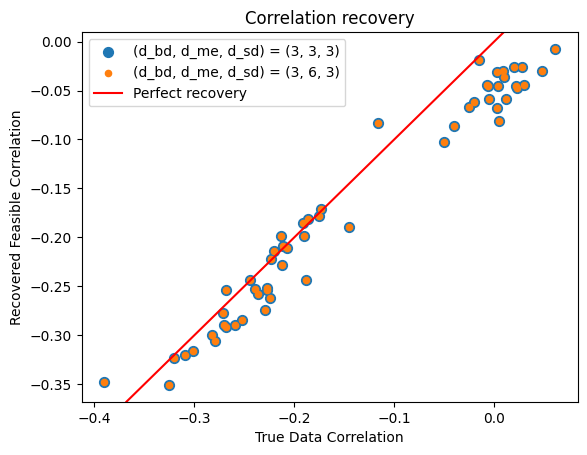

In [172]:
plt.title("Correlation recovery")
plt.xlabel("True Data Correlation")
plt.ylabel("Recovered Feasible Correlation")
plt.scatter(correlations_data, correlations_same, s=50, label=f"(d_bd, d_me, d_sd) = ({d_bd}, {d_me}, {d_sd})")
plt.scatter(correlations_data, correlations_me, s=20, label=f"(d_bd, d_me, d_sd) = ({d_bd}, {d_me + d_inc}, {d_sd})")
a = np.mean(correlations_data)
plt.axline([a, a], [a + 0.001, a + 0.001], color="red", label="Perfect recovery")
plt.legend()
plt.show()

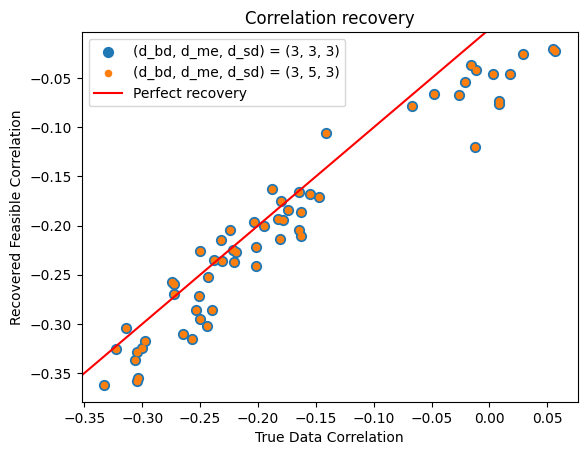

In [170]:
plt.title("Correlation recovery")
plt.xlabel("True Data Correlation")
plt.ylabel("Recovered Feasible Correlation")
plt.scatter(correlations_data, correlations_same, s=50, label=f"(d_bd, d_me, d_sd) = ({d_bd}, {d_me}, {d_sd})")
plt.scatter(correlations_data, correlations_me, s=20, label=f"(d_bd, d_me, d_sd) = ({d_bd}, {d_me + d_inc}, {d_sd})")
a = np.mean(correlations_data)
plt.axline([a, a], [a + 0.001, a + 0.001], color="red", label="Perfect recovery")
plt.legend()
plt.show()

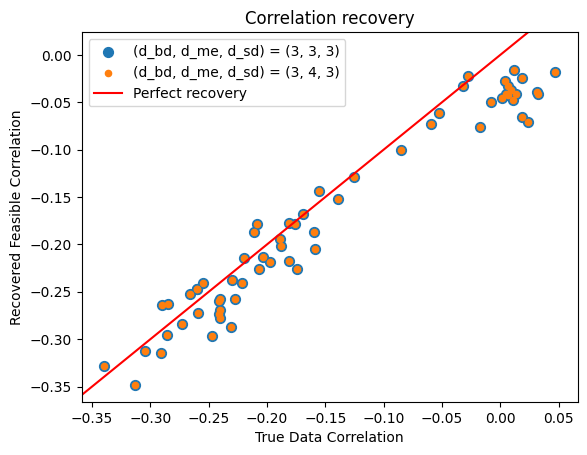

In [168]:
plt.title("Correlation recovery")
plt.xlabel("True Data Correlation")
plt.ylabel("Recovered Feasible Correlation")
plt.scatter(correlations_data, correlations_same, s=50, label=f"(d_bd, d_me, d_sd) = ({d_bd}, {d_me}, {d_sd})")
plt.scatter(correlations_data, correlations_me, s=20, label=f"(d_bd, d_me, d_sd) = ({d_bd}, {d_me + d_inc}, {d_sd})")
a = np.mean(correlations_data)
plt.axline([a, a], [a + 0.001, a + 0.001], color="red", label="Perfect recovery")
plt.legend()
plt.show()

In [178]:
# store "truth"
correlations_data = []
status_data = []

# store results: same order
correlations_same = []
status_same = []

# store results: increased moment equation order
correlations_me = []
status_me = []

# settings
N = 100
n = 1000
d_bd = 3
d_me = 3
d_sd = 3
d_inc = 3
factorization = False
mean_capture = 0.75
confidence = 0.5

# for each repeat
for i in tqdm.tqdm(range(N)):

    # sample paramters from prior
    k_off = rng.integers(0, 2)
    k_tx = rng.integers(1, 3)
    k_reg = rng.integers(0, 3)
    params = {
        'k_on_1': 1,
        'k_on_2': 1,
        'k_off_1': k_off,
        'k_off_2': k_off,
        'k_tx_1':  k_tx,
        'k_tx_2':  k_tx,
        'k_deg_1': 1,
        'k_deg_2': 1,
        'k_reg':   k_reg
    }

    # store status (Birth-Death model feasibility)
    if k_off == 0:
        status_data.append("OPTIMAL")
    else:
        status_data.append("INFEASIBLE")

    # simulate data
    sample = gillespie_birth_death(params, n)

    # downsample
    downsample, beta = downsample_data(sample, mean_capture)

    # data correlations
    rho, p = scipy.stats.pearsonr([x[0] for x in sample], [x[1] for x in sample])
    correlations_data.append(float(rho))

    # bootstrap
    OB_bounds = bootstrap(downsample, d_bd, 1000, confidence=confidence)

    # optimize with default order
    solution_same, _, _, feasible_values_same = feasibility_BD(d_bd, d_me, d_sd, factorization)

    # store results
    status_same.append(solution_same['status'])
    if solution_same['status'] == "OPTIMAL":
        correlations_same.append(compute_feasible_correlation(2, max(d_bd, d_me, d_sd), solution_same, feasible_values_same))
    else:
        correlations_same.append(None)

    # optimize with higher order
    solution_me, _, _, feasible_values_me = feasibility_BD(d_bd, d_me + d_inc, d_sd, factorization)

    # store results
    status_me.append(solution_me['status'])
    if solution_me['status'] == "OPTIMAL":
        correlations_me.append(compute_feasible_correlation(2, max(d_bd, d_me + d_inc, d_sd), solution_me, feasible_values_me))
    else:
        correlations_me.append(None)

100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


In [179]:
def confusion_matrix_BD(status_data, status_model):
    confusion_df = pd.DataFrame(
        [[0, 0], [0, 0]],
        index = ["Feasible", "Infeasible"],
        columns=["Feasible", "Infeasible"]
    )
    for i, truth in enumerate(status_data):
        if truth == "OPTIMAL":
            if status_model[i] == "OPTIMAL":
                confusion_df.iloc[0, 0] += 1
            else:
                confusion_df.iloc[0, 1] += 1
        else:
            if status_model[i] == "OPTIMAL":
                confusion_df.iloc[1, 0] += 1
            else:
                confusion_df.iloc[1, 1] += 1
    confusion_df = confusion_df / len(status_data)

    return confusion_df

In [180]:
# (d_bd, d_me, d_sd) = (3, 3, 3)
# rows = data, columns = model
# feasibility under birth-death model
confusion_matrix_BD(status_data, status_same)

,Feasible,Infeasible
Feasible,0.50,0.00
Infeasible,0.49,0.01


In [181]:
# (d_bd, d_me, d_sd) = (3, 6, 3)
# rows = data, columns = model
# feasibility under birth-death model
confusion_matrix_BD(status_data, status_me)

,Feasible,Infeasible
Feasible,0.50,0.00
Infeasible,0.49,0.01


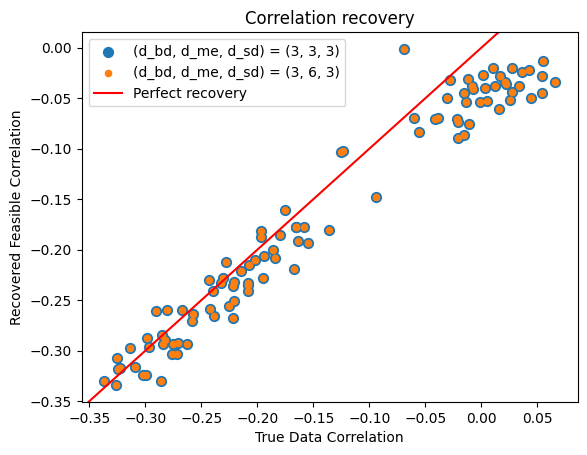

In [182]:
plt.title("Correlation recovery")
plt.xlabel("True Data Correlation")
plt.ylabel("Recovered Feasible Correlation")
plt.scatter(correlations_data, correlations_same, s=50, label=f"(d_bd, d_me, d_sd) = ({d_bd}, {d_me}, {d_sd})")
plt.scatter(correlations_data, correlations_me, s=20, label=f"(d_bd, d_me, d_sd) = ({d_bd}, {d_me + d_inc}, {d_sd})")
a = np.mean(correlations_data)
plt.axline([a, a], [a + 0.001, a + 0.001], color="red", label="Perfect recovery")
plt.legend()
plt.show()

## Telegraph

In [186]:
def feasibility_TE(d_bd, d_me, d_sd, factorization=True):

    # settings
    reactions = [
        "1 - xs[2]",
        "xs[2]",
        "xs[2]",
        "xs[0]",
        "1 - xs[3]",
        "xs[3]",
        "xs[3]",
        "xs[1]",
        "xs[0] * xs[1]"
    ]
    vrs = [
        [0, 0, 1, 0],
        [0, 0, -1, 0],
        [1, 0, 0, 0],
        [-1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, -1],
        [0, 1, 0, 0],
        [0, -1, 0, 0],
        [-1, -1, 0, 0]
    ]
    db = 2
    R = 9
    S = 4
    U = [2, 3]
    fixed = [(7, 1)]

    # constraints
    constraints = {
        'moment_bounds':           True,
        'moment_matrices':         True,
        'moment_equations':        True,
        'factorization':           False,
        'telegraph_factorization': factorization,
        'telegraph_moments':       True,
        'telegraph_moments_ineq':  True
    }

    # test feasibility
    solution, eigenvalues, optim_times, feasible_values = feasibility_test(
        OB_bounds,
        beta,
        reactions,
        vrs,
        db,
        R,
        S,
        U, 
        d_bd,
        d_me,
        d_sd,
        constraints,
        fixed=fixed,
        time_limit=300,
        K=100, # use 100 here as know parameters are well below
        print_evals=False,
        eval_eps=10**-6,
        printing=False,
        silent=True,
        write_model=False,
        cut_limit=100,
        total_time_limit=300
    )

    return solution, eigenvalues, optim_times, feasible_values

In [194]:
# store "truth"
correlations_data = []
status_data = []

# store results: same order
correlations_same = []
status_same = []

# store results: increased moment equation order
correlations_me = []
status_me = []

# settings
N = 100
n = 1000
d_bd = 3
d_me = 3
d_sd = 3
d_inc = 3
factorization = True
mean_capture = 0.75
confidence = 0.5

# for each repeat
for i in tqdm.tqdm(range(N)):

    # sample paramters from prior
    k_off = rng.integers(0, 2)
    k_tx = rng.integers(1, 3)
    k_reg = rng.integers(0, 3)
    params = {
        'k_on_1': 1,
        'k_on_2': 1,
        'k_off_1': k_off,
        'k_off_2': k_off,
        'k_tx_1':  k_tx,
        'k_tx_2':  k_tx,
        'k_deg_1': 1,
        'k_deg_2': 1,
        'k_reg':   k_reg
    }

    # store status
    if k_reg == 0:
        status_data.append("INDEPENDENT")
    else:
        status_data.append("DEPENDENT")

    # simulate data
    sample = gillespie_birth_death(params, n)

    # downsample
    downsample, beta = downsample_data(sample, mean_capture)

    # data correlations
    rho, p = scipy.stats.pearsonr([x[0] for x in sample], [x[1] for x in sample])
    correlations_data.append(float(rho))

    # bootstrap
    OB_bounds = bootstrap(downsample, d_bd, 1000, confidence=confidence)

    # optimize with default order
    solution_same, _, _, feasible_values_same = feasibility_TE(d_bd, d_me, d_sd, factorization)

    # store results
    status_same.append(solution_same['status'])
    if solution_same['status'] == "OPTIMAL":
        correlations_same.append(compute_feasible_correlation(2, max(d_bd, d_me, d_sd), solution_same, feasible_values_same))
    else:
        correlations_same.append(None)

    # optimize with higher order
    solution_me, _, _, feasible_values_me = feasibility_TE(d_bd, d_me + d_inc, d_sd, factorization)

    # store results
    status_me.append(solution_me['status'])
    if solution_me['status'] == "OPTIMAL":
        correlations_me.append(compute_feasible_correlation(2, max(d_bd, d_me + d_inc, d_sd), solution_me, feasible_values_me))
    else:
        correlations_me.append(None)

  3%|▎         | 3/100 [00:03<02:07,  1.32s/it]C:\Users\willi\AppData\Local\Temp\ipykernel_15556\1514784868.py:34: RuntimeWarning: invalid value encountered in sqrt
  correlation = (E_xy - E_x*E_y) / (np.sqrt(E_x2 - E_x**2) * np.sqrt(E_y2 - E_y**2))
100%|██████████| 100/100 [13:29<00:00,  8.09s/it]  


In [195]:
# (d_bd, d_me, d_sd) = (3, 3, 3)
# rows = data, columns = model
confusion_matrix_ind(status_data, status_same)

,Independent,Dependent
Independent,0.24,0.02
Dependent,0.00,0.74


In [196]:
# (d_bd, d_me, d_sd) = (3, 3, 3)
# rows = data, columns = model
confusion_matrix_ind(status_data, status_same)

,Independent,Dependent
Independent,0.24,0.02
Dependent,0.00,0.74


In [203]:
# store "truth"
correlations_data = []
status_data = []

# store results: same order
correlations_same = []
status_same = []

# store results: increased moment equation order
correlations_me = []
status_me = []

# settings
N = 100
n = 1000
d_bd = 3
d_me = 3
d_sd = 3
d_inc = 3
factorization = False
mean_capture = 0.75
confidence = 0.5

# for each repeat
for i in tqdm.tqdm(range(N)):

    # sample paramters from prior
    k_off = rng.integers(0, 2)
    k_tx = rng.integers(1, 3)
    k_reg = rng.integers(0, 3)
    params = {
        'k_on_1': 1,
        'k_on_2': 1,
        'k_off_1': k_off,
        'k_off_2': k_off,
        'k_tx_1':  k_tx,
        'k_tx_2':  k_tx,
        'k_deg_1': 1,
        'k_deg_2': 1,
        'k_reg':   k_reg
    }

    # store status
    if k_reg == 0:
        status_data.append("INDEPENDENT")
    else:
        status_data.append("DEPENDENT")

    # simulate data
    sample = gillespie_birth_death(params, n)

    # downsample
    downsample, beta = downsample_data(sample, mean_capture)

    # data correlations
    rho, p = scipy.stats.pearsonr([x[0] for x in sample], [x[1] for x in sample])
    correlations_data.append(float(rho))

    # bootstrap
    OB_bounds = bootstrap(downsample, d_bd, 1000, confidence=confidence)

    # optimize with default order
    solution_same, _, _, feasible_values_same = feasibility_TE(d_bd, d_me, d_sd, factorization)

    # store results
    status_same.append(solution_same['status'])
    if solution_same['status'] == "OPTIMAL":
        correlations_same.append(compute_feasible_correlation(4, max(d_bd, d_me, d_sd), solution_same, feasible_values_same))
    else:
        correlations_same.append(None)

    # optimize with higher order
    solution_me, _, _, feasible_values_me = feasibility_TE(d_bd, d_me + d_inc, d_sd, factorization)

    # store results
    status_me.append(solution_me['status'])
    if solution_me['status'] == "OPTIMAL":
        correlations_me.append(compute_feasible_correlation(4, max(d_bd, d_me + d_inc, d_sd), solution_me, feasible_values_me))
    else:
        correlations_me.append(None)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [13:01<00:00,  7.81s/it]  


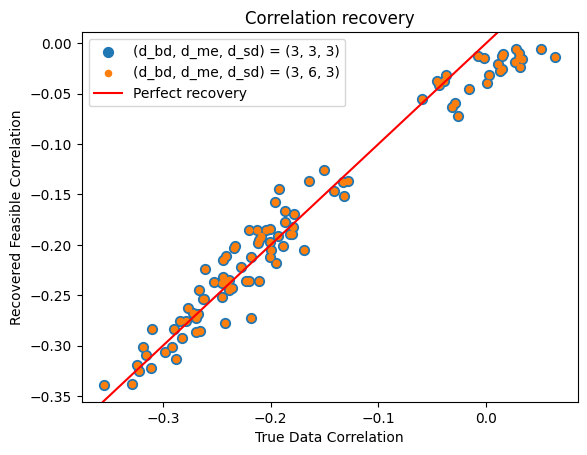

In [204]:
plt.title("Correlation recovery")
plt.xlabel("True Data Correlation")
plt.ylabel("Recovered Feasible Correlation")
plt.scatter(correlations_data, correlations_same, s=50, label=f"(d_bd, d_me, d_sd) = ({d_bd}, {d_me}, {d_sd})")
plt.scatter(correlations_data, correlations_me, s=20, label=f"(d_bd, d_me, d_sd) = ({d_bd}, {d_me + d_inc}, {d_sd})")
a = np.mean(correlations_data)
plt.axline([a, a], [a + 0.001, a + 0.001], color="red", label="Perfect recovery")
plt.legend()
plt.show()

# Real data

In [16]:
# read fibroblast transcript counts
data_FIB = pd.read_csv("../Real-Data-2/Data/GSE151334_FIB_counts_thresh.csv", index_col=0)

# load capture
beta = np.loadtxt("../Real-Data-2/Capture/beta_FIB.txt")

# load RNA types
biotypes_dict = json.load(open("../Real-Data-2/Biotypes/biotypes_FIB.json"))

# select indices of protein coding mRNA and non-coding miRNA
pcRNA_indices = [idx for idx, btype in enumerate(biotypes_dict.values()) if btype == "protein_coding"]
miRNA_indices = [idx for idx, btype in enumerate(biotypes_dict.values()) if btype == "miRNA"]

# separate data
data_FIB_pcRNA = data_FIB.iloc[pcRNA_indices]
data_FIB_miRNA = data_FIB.iloc[miRNA_indices]

In [18]:
# select
miRNA = "MIR100"
mRNA_idx = 1

# construct sample
sample_miRNA = data_FIB_miRNA.loc[miRNA]
sample_mRNA = data_FIB_pcRNA.iloc[mRNA_idx]
sample = list(zip(sample_miRNA, sample_mRNA))

## Single sample

In [19]:
# settings
reactions = [
    "1",
    "xs[0]",
    "1",
    "xs[1]",
    "xs[0] * xs[1]"
]
vrs = [
    [1, 0],
    [-1, 0],
    [0, 1],
    [0, -1],
    [-1, -1]
]
db = 2
R = 5
S = 2
U = []
fixed = [(3, 1)]

# order
d_boot = 4

# constraints
constraints = {
    'moment_bounds':           True,
    'moment_matrices':         True,
    'moment_equations':        True,
    'factorization':           True,
    'telegraph_factorization': False,
    'telegraph_moments':       False,
    'telegraph_moments_ineq':  False
}

# bootstrap
OB_bounds = bootstrap(sample, d_boot, resamples=1000)

In [20]:
# order
d_bd = 2
d_me = 2
d_sd = 2

# test feasibility
solution, eigenvalues, optim_times, feasible_values = feasibility_test(
    OB_bounds,
    beta,
    reactions,
    vrs,
    db,
    R,
    S,
    U, 
    d_bd,
    d_me,
    d_sd,
    constraints,
    fixed=fixed,
    time_limit=300,
    K=None,
    print_evals=False,
    eval_eps=10**-6,
    printing=True,
    silent=True,
    write_model=False,
    cut_limit=100,
    total_time_limit=300
)

solution

SDP feasible



{'status': 'OPTIMAL', 'time': 0.06299996376037598, 'cuts': 0}

In [21]:
# order
d_bd = 2
d_me = 3
d_sd = 2

# test feasibility
solution, eigenvalues, optim_times, feasible_values = feasibility_test(
    OB_bounds,
    beta,
    reactions,
    vrs,
    db,
    R,
    S,
    U, 
    d_bd,
    d_me,
    d_sd,
    constraints,
    fixed=fixed,
    time_limit=300,
    K=None,
    print_evals=False,
    eval_eps=10**-6,
    printing=True,
    silent=True,
    write_model=False,
    cut_limit=100,
    total_time_limit=300
)

solution

{'status': 'INFEASIBLE', 'time': 0.06299996376037598, 'cuts': 0}

In [23]:
# orders
order_list = [
    (2, 2, 2),
    (3, 2, 2),
    (2, 3, 2),
    (2, 2, 3)
]

for d_bd, d_me, d_sd in order_list:

    # test feasibility
    solution, eigenvalues, optim_times, feasible_values = feasibility_test(
        OB_bounds,
        beta,
        reactions,
        vrs,
        db,
        R,
        S,
        U, 
        d_bd,
        d_me,
        d_sd,
        constraints,
        fixed=fixed,
        time_limit=300,
        K=None,
        print_evals=False,
        eval_eps=10**-6,
        printing=False,
        silent=True,
        write_model=False,
        cut_limit=100,
        total_time_limit=300
    )

    print(f"(d_bd d_me, d_sd) = ({d_bd}, {d_me}, {d_sd})")
    print(solution)

(d_bd d_me, d_sd) = (2, 2, 2)
{'status': 'OPTIMAL', 'time': 0.003000020980834961, 'cuts': 0}
(d_bd d_me, d_sd) = (3, 2, 2)
{'status': 'OPTIMAL', 'time': 0.012000083923339844, 'cuts': 0}
(d_bd d_me, d_sd) = (2, 3, 2)
{'status': 'INFEASIBLE', 'time': 0.029999971389770508, 'cuts': 0}
(d_bd d_me, d_sd) = (2, 2, 3)
{'status': 'OPTIMAL', 'time': 0.03399991989135742, 'cuts': 15}


### Notes

- some evidence on real data that increasing d_me alone can change feasibility (feas -> inf)
- NOTE: K = None used

## Multiple samples

### Effect of + 1 to each order

In [ ]:
# settings
reactions = [
    "1",
    "xs[0]",
    "1",
    "xs[1]",
    "xs[0] * xs[1]"
]
vrs = [
    [1, 0],
    [-1, 0],
    [0, 1],
    [0, -1],
    [-1, -1]
]
db = 2
R = 5
S = 2
U = []
fixed = [(3, 1)]

# constraints
constraints = {
    'moment_bounds':           True,
    'moment_matrices':         True,
    'moment_equations':        True,
    'factorization':           False,
    'telegraph_factorization': False,
    'telegraph_moments':       False,
    'telegraph_moments_ineq':  False
}

# select
miRNA = "MIR100"
N = 20
d = 3
c = 0.95
order_list = [
    (d, d, d),
    (d + 1, d, d),
    (d, d + 1, d),
    (d, d, d + 1)
]

status_array = [["" for _ in order_list] for _ in range(N)]
time_array = [[0 for _ in order_list] for _ in range(N)]
cut_array = [[0 for _ in order_list] for _ in range(N)]

# for each mRNA
for mRNA_idx in tqdm.tqdm(range(N)):

    # construct sample
    sample_miRNA = data_FIB_miRNA.loc[miRNA]
    sample_mRNA = data_FIB_pcRNA.iloc[mRNA_idx]
    sample = list(zip(sample_miRNA, sample_mRNA))

    # bootstrap
    OB_bounds = bootstrap(sample, d + 1, resamples=1000, confidence=c)

    # for each order setting
    for d_idx, (d_bd, d_me, d_sd) in enumerate(order_list):
            
        # test feasibility
        solution, eigenvalues, optim_times, feasible_values = feasibility_test(
            OB_bounds,
            beta,
            reactions,
            vrs,
            db,
            R,
            S,
            U, 
            d_bd,
            d_me,
            d_sd,
            constraints,
            fixed=fixed,
            time_limit=10,
            K=None,
            print_evals=False,
            eval_eps=10**-6,
            printing=False,
            silent=True,
            write_model=False,
            cut_limit=100,
            total_time_limit=300
        )

        # store results
        status_array[mRNA_idx][d_idx] = solution['status']
        time_array[mRNA_idx][d_idx] = solution['time']
        cut_array[mRNA_idx][d_idx] = solution['cuts']
    

100%|██████████| 20/20 [01:23<00:00,  4.18s/it]


In [67]:
status_array

[['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['TIME_LIMIT', 'OPTIMAL', 'OPTIMAL', 'TIME_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL', 'CUT_LIMIT']]

### Effect of + x to d_me

In [78]:
# settings
reactions = [
    "1",
    "xs[0]",
    "1",
    "xs[1]",
    "xs[0] * xs[1]"
]
vrs = [
    [1, 0],
    [-1, 0],
    [0, 1],
    [0, -1],
    [-1, -1]
]
db = 2
R = 5
S = 2
U = []
fixed = [(3, 1)]

# constraints
constraints = {
    'moment_bounds':           True,
    'moment_matrices':         True,
    'moment_equations':        True,
    'factorization':           False,
    'telegraph_factorization': False,
    'telegraph_moments':       False,
    'telegraph_moments_ineq':  False
}

# select
miRNA = "MIR100"
N = 20
d = 3
n = 2
c = 0.75
order_list = [
    (d, d + x, d) for x in range(n + 1)
]

status_array = [["" for _ in order_list] for _ in range(N)]
time_array = [[0 for _ in order_list] for _ in range(N)]
cut_array = [[0 for _ in order_list] for _ in range(N)]

# for each mRNA
for mRNA_idx in tqdm.tqdm(range(N)):

    # construct sample
    sample_miRNA = data_FIB_miRNA.loc[miRNA]
    sample_mRNA = data_FIB_pcRNA.iloc[mRNA_idx]
    sample = list(zip(sample_miRNA, sample_mRNA))

    # bootstrap
    OB_bounds = bootstrap(sample, d + n, resamples=1000, confidence=c)

    # for each order setting
    for d_idx, (d_bd, d_me, d_sd) in enumerate(order_list):
            
        # test feasibility
        solution, eigenvalues, optim_times, feasible_values = feasibility_test(
            OB_bounds,
            beta,
            reactions,
            vrs,
            db,
            R,
            S,
            U, 
            d_bd,
            d_me,
            d_sd,
            constraints,
            fixed=fixed,
            time_limit=30,
            K=None,
            print_evals=False,
            eval_eps=10**-6,
            printing=False,
            silent=True,
            write_model=False,
            cut_limit=100,
            total_time_limit=30
        )

        # store results
        status_array[mRNA_idx][d_idx] = solution['status']
        time_array[mRNA_idx][d_idx] = solution['time']
        cut_array[mRNA_idx][d_idx] = solution['cuts']

100%|██████████| 20/20 [02:53<00:00,  8.66s/it]


In [79]:
status_array

[['INFEASIBLE', 'INFEASIBLE', 'INFEASIBLE'],
 ['INFEASIBLE', 'INFEASIBLE', 'INFEASIBLE'],
 ['INFEASIBLE', 'INFEASIBLE', 'INFEASIBLE'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL'],
 ['INFEASIBLE', 'INFEASIBLE', 'INFEASIBLE'],
 ['OPTIMAL', 'OPTIMAL', 'TIME_LIMIT'],
 ['INFEASIBLE', 'INFEASIBLE', 'INFEASIBLE'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL'],
 ['INFEASIBLE', 'INFEASIBLE', 'INFEASIBLE'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL', 'TIME_LIMIT'],
 ['INFEASIBLE', 'INFEASIBLE', 'INFEASIBLE'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL', 'TIME_LIMIT'],
 ['OPTIMAL', 'OPTIMAL', 'OPTIMAL'],
 ['INFEASIBLE', 'INFEASIBLE', 'TIME_LIMIT']]

In [80]:
time_array

[[0.020999908447265625, 0.003999948501586914, 0.0],
 [0.002000093460083008, 0.002000093460083008, 0.0],
 [0.014999866485595703, 0.0, 0.00800013542175293],
 [0.017999887466430664, 0.0, 2.9800000190734863],
 [0.3169999122619629, 1.0, 2.450000286102295],
 [0.0, 0.004000186920166016, 0.016000032424926758],
 [0.0, 0.49199986457824707, 30.00100016593933],
 [0.0, 0.0, 0.016000032424926758],
 [0.04500007629394531, 0.0, 0.8540000915527344],
 [0.002000093460083008, 0.16100001335144043, 3.4049999713897705],
 [0.08699989318847656, 0.0, 5.551999807357788],
 [0.006000041961669922, 0.014999866485595703, 0.00599980354309082],
 [0.1380000114440918, 0.0, 2.7910001277923584],
 [0.0070002079010009766, 0.8869998455047607, 30.00499987602234],
 [0.0, 0.0, 0.021000146865844727],
 [0.014999866485595703, 1.189000129699707, 0.7009999752044678],
 [0.0, 0.0, 5.5899999141693115],
 [0.003999948501586914, 0.003999948501586914, 38.073999881744385],
 [0.00599980354309082, 0.015999794006347656, 8.069999694824219],
 [0.1

### Repeat with telegraph

In [96]:
# settings
reactions = [
    "1 - xs[2]",
    "xs[2]",
    "xs[2]",
    "xs[0]",
    "1 - xs[3]",
    "xs[3]",
    "xs[3]",
    "xs[1]",
    "xs[0] * xs[1]"
]
vrs = [
    [0, 0, 1, 0],
    [0, 0, -1, 0],
    [1, 0, 0, 0],
    [-1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 0, -1],
    [0, 1, 0, 0],
    [0, -1, 0, 0],
    [-1, -1, 0, 0]
]
db = 2
R = 9
S = 4
U = [2, 3]
fixed = [(7, 1)]

# constraints
constraints = {
    'moment_bounds':           True,
    'moment_matrices':         True,
    'moment_equations':        True,
    'factorization':           False,
    'telegraph_factorization': False,
    'telegraph_moments':       True,
    'telegraph_moments_ineq':  True
}

# select
miRNA = "MIR100"
N1, N2 = 10, 100
d = 3
n = 1
c = 0.5
order_list = [
    (d, d + x, d) for x in range(n + 1)
]

status_array = [["" for _ in order_list] for _ in range(N2 - N1)]
time_array = [[0 for _ in order_list] for _ in range(N2 - N1)]
cut_array = [[0 for _ in order_list] for _ in range(N2 - N1)]

# for each mRNA
for i in tqdm.tqdm(range(N2 - N1)):

    miRNA_idx = i + N1

    # construct sample
    sample_miRNA = data_FIB_miRNA.loc[miRNA]
    sample_mRNA = data_FIB_pcRNA.iloc[mRNA_idx]
    sample = list(zip(sample_miRNA, sample_mRNA))

    # bootstrap
    OB_bounds = bootstrap(sample, d + n, resamples=1000, confidence=c)

    # for each order setting
    for d_idx, (d_bd, d_me, d_sd) in enumerate(order_list):
            
        # test feasibility
        solution, eigenvalues, optim_times, feasible_values = feasibility_test(
            OB_bounds,
            beta,
            reactions,
            vrs,
            db,
            R,
            S,
            U, 
            d_bd,
            d_me,
            d_sd,
            constraints,
            fixed=fixed,
            time_limit=30,
            K=None,
            print_evals=False,
            eval_eps=10**-6,
            printing=False,
            silent=True,
            write_model=False,
            cut_limit=100,
            total_time_limit=30
        )

        # store results
        status_array[i][d_idx] = solution['status']
        time_array[i][d_idx] = solution['time']
        cut_array[i][d_idx] = solution['cuts']

100%|██████████| 90/90 [07:35<00:00,  5.06s/it]


In [97]:
status_array

[['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'TIME_LIMIT'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'OPTIMAL'],
 ['OPTIMAL', 'TIME_LIM

In [98]:
time_array

[[0.1679999828338623, 0.054000139236450195],
 [0.20000004768371582, 0.11299991607666016],
 [0.37600040435791016, 3.0699996948242188],
 [2.2019999027252197, 0.059999942779541016],
 [0.23200011253356934, 0.04999995231628418],
 [0.16499972343444824, 0.06500005722045898],
 [0.46400022506713867, 30.005000114440918],
 [1.5389997959136963, 0.7919998168945312],
 [0.21500015258789062, 0.8040001392364502],
 [0.5439999103546143, 0.08500003814697266],
 [1.8239998817443848, 0.04699993133544922],
 [0.22500014305114746, 0.04399991035461426],
 [0.07200002670288086, 0.15900015830993652],
 [0.693000078201294, 0.8310000896453857],
 [0.21700000762939453, 0.05200004577636719],
 [1.1009995937347412, 0.875999927520752],
 [0.13099980354309082, 0.04699993133544922],
 [2.4710001945495605, 0.13199996948242188],
 [0.31599998474121094, 0.13100004196166992],
 [0.9909999370574951, 0.051000118255615234],
 [0.5220003128051758, 27.667999505996704],
 [0.11500000953674316, 0.04699993133544922],
 [4.164000034332275, 0.815